In [1]:
pip install requests

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os

import pyspark
from pyspark.sql import SparkSession

conf = (
    pyspark.SparkConf()
        .setAppName('app_name')
        #packages
        .set('spark.jars.packages', 'org.apache.iceberg:iceberg-spark-runtime-3.3_2.12:1.4.3,software.amazon.awssdk:bundle:2.17.178,software.amazon.awssdk:url-connection-client:2.17.178')
        #SQL Extensions
        .set('spark.sql.extensions', 'org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions')
        #Configuring Catalog
        .set('spark.sql.catalog.iceberg', 'org.apache.iceberg.spark.SparkCatalog')
        .set('spark.sql.catalog.iceberg.type', 'hadoop')
        .set('spark.sql.catalog.iceberg.warehouse', 'iceberg-warehouse')
)

## Start Spark Session
spark = SparkSession.builder.config(conf=conf).getOrCreate()
print("Spark Running")

:: loading settings :: url = jar:file:/home/docker/.local/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/docker/.ivy2/cache
The jars for the packages stored in: /home/docker/.ivy2/jars
org.apache.iceberg#iceberg-spark-runtime-3.3_2.12 added as a dependency
software.amazon.awssdk#bundle added as a dependency
software.amazon.awssdk#url-connection-client added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-9b520ba1-522e-4a7f-8ad9-4d599f4d5b56;1.0
	confs: [default]
	found org.apache.iceberg#iceberg-spark-runtime-3.3_2.12;1.4.3 in central
	found software.amazon.awssdk#bundle;2.17.178 in central
	found software.amazon.eventstream#eventstream;1.0.1 in central
	found software.amazon.awssdk#url-connection-client;2.17.178 in central
	found software.amazon.awssdk#utils;2.17.178 in central
	found org.reactivestreams#reactive-streams;1.0.3 in central
	found software.amazon.awssdk#annotations;2.17.178 in central
	found org.slf4j#slf4j-api;1.7.30 in central
	found software.amazon.awssdk#http-client-spi;2.17.178 in central
	found software

25/04/25 23:12:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Spark Running


In [5]:
#Retrieve a list of all cryptocurrencies with id, name, and symbol (using the CoinGecko API)

import requests

apiKey="?x_cg_demo_api_key=CG-n6T33SZ3joMrNew9wNCsAmtn"
url = "https://api.coingecko.com/api/v3/coins/list"+apiKey

headers = {"accept": "application/json"}
response = requests.get(url, headers=headers)

respuesta=response.text

In [7]:
import json
#Cargar la respuesta en un JSON
lista = json.loads(respuesta)

#longitud del arreglo
len(lista)

16988

In [8]:
#Creación del dataframe y verificar la cifra
dfLista = spark.createDataFrame(lista)
dfLista.show()
dfLista.count()

+--------------------+--------------------+------+
|                  id|                name|symbol|
+--------------------+--------------------+------+
|                   _|        ༼ つ ◕_◕ ༽つ|   gib|
|              01coin|              01coin|   zoc|
|              0chain|                 Zus|   zcn|
|                0dog|        Bitcoin Dogs|  0dog|
| 0-knowledge-network| 0 Knowledge Network|   0kn|
|               0-mee|               O-MEE|   ome|
|       0vix-protocol|       0VIX Protocol|   vix|
|                  0x|         0x Protocol|   zrx|
|0x0-ai-ai-smart-c...|0x0.ai: AI Smart ...|   0x0|
| 0x678-landwolf-1933|            Landwolf|  wolf|
|              0xcoco|              0xCoco|  coco|
|         0xgasless-2|           0xGasless| 0xgas|
|               0xgen|               0xGen|   xgn|
|         0x-leverage|         0x Leverage|   oxl|
|                0xlp|       OpenLiquidity|openli|
|               0xlsd|               0xLSD| 0xlsd|
|              0xmonk|  0xMonk by

16988

In [11]:
#Crear la tabla Iceberg
spark.sql("CREATE TABLE iceberg.AllCrytoCurrencies (id string, symbol string, name string) USING iceberg;")

# Cambiar de DataFrame a Tabla Iceberg
dfLista.writeTo("iceberg.AllCrytoCurrencies").using("iceberg").createOrReplace()

# Query para visualizar la información
spark.sql("SELECT * FROM iceberg.AllCrytoCurrencies").show()
# Query para contar el número de registros
spark.sql("SELECT count(*) FROM iceberg.AllCrytoCurrencies").show()

+--------------------+--------------------+------+
|                  id|                name|symbol|
+--------------------+--------------------+------+
|                   _|        ༼ つ ◕_◕ ༽つ|   gib|
|              01coin|              01coin|   zoc|
|              0chain|                 Zus|   zcn|
|                0dog|        Bitcoin Dogs|  0dog|
| 0-knowledge-network| 0 Knowledge Network|   0kn|
|               0-mee|               O-MEE|   ome|
|       0vix-protocol|       0VIX Protocol|   vix|
|                  0x|         0x Protocol|   zrx|
|0x0-ai-ai-smart-c...|0x0.ai: AI Smart ...|   0x0|
| 0x678-landwolf-1933|            Landwolf|  wolf|
|              0xcoco|              0xCoco|  coco|
|         0xgasless-2|           0xGasless| 0xgas|
|               0xgen|               0xGen|   xgn|
|         0x-leverage|         0x Leverage|   oxl|
|                0xlp|       OpenLiquidity|openli|
|               0xlsd|               0xLSD| 0xlsd|
|              0xmonk|  0xMonk by

In [12]:
#Retrieve the Bitcoin coin id
spark.sql("SELECT id FROM iceberg.AllCrytoCurrencies where name ='Bitcoin'").show()

+-------+
|     id|
+-------+
|bitcoin|
+-------+



In [13]:
#Get Bitcoin’s price in USD and by date for the last quarter of 2024 (using the CoinGecko API)
#No fue posible el primer trimestre de 2022 debido a que se necesita un perfil de pago
apiKey="?x_cg_demo_api_key=CG-n6T33SZ3joMrNew9wNCsAmtn"
url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range?vs_currency=usd&from=1725148800&to=1735689599"+apiKey

headers = {"accept": "application/json"}
response = requests.get(url, headers=headers)

respuestaUSD=response.text

In [14]:
#Cargar la respuesta en un JSON
listaUSD = json.loads(respuestaUSD)

In [16]:
#cambiar el formato de la fecha
import time

listaUSDate=[]
for lis in listaUSD["prices"]:
    listaUSDate.append({"fecha":time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime(int(str(lis[0])[:-3]))),
                        "USD":lis[1]})

In [17]:
#Verificar datos
listaUSDate

[{'fecha': '2024-09-01 00:00:00', 'USD': 58960.23658664587},
 {'fecha': '2024-09-02 00:00:00', 'USD': 57357.71617282246},
 {'fecha': '2024-09-03 00:00:00', 'USD': 59108.73235863689},
 {'fecha': '2024-09-04 00:00:00', 'USD': 57504.538586220435},
 {'fecha': '2024-09-05 00:00:00', 'USD': 57987.84601410068},
 {'fecha': '2024-09-06 00:00:00', 'USD': 56132.404732088595},
 {'fecha': '2024-09-07 00:00:00', 'USD': 53923.35611071905},
 {'fecha': '2024-09-08 00:00:00', 'USD': 54150.9383589072},
 {'fecha': '2024-09-09 00:00:00', 'USD': 54792.40755768575},
 {'fecha': '2024-09-10 00:00:00', 'USD': 57049.118751143265},
 {'fecha': '2024-09-11 00:00:00', 'USD': 57624.16178336144},
 {'fecha': '2024-09-12 00:00:00', 'USD': 57381.764445000474},
 {'fecha': '2024-09-13 00:00:00', 'USD': 58106.951229815284},
 {'fecha': '2024-09-14 00:00:00', 'USD': 60620.62747295754},
 {'fecha': '2024-09-15 00:00:00', 'USD': 60003.29940083042},
 {'fecha': '2024-09-16 00:00:00', 'USD': 59214.80226801806},
 {'fecha': '2024-09-

In [18]:
#largo de la lista
len(listaUSDate)

122

In [19]:
#Creación del dataframe y verificar la cifra
dfListaUSD = spark.createDataFrame(listaUSDate)
dfListaUSD.show()
dfListaUSD.count()

+------------------+-------------------+
|               USD|              fecha|
+------------------+-------------------+
| 58960.23658664587|2024-09-01 00:00:00|
| 57357.71617282246|2024-09-02 00:00:00|
| 59108.73235863689|2024-09-03 00:00:00|
|57504.538586220435|2024-09-04 00:00:00|
| 57987.84601410068|2024-09-05 00:00:00|
|56132.404732088595|2024-09-06 00:00:00|
| 53923.35611071905|2024-09-07 00:00:00|
|  54150.9383589072|2024-09-08 00:00:00|
| 54792.40755768575|2024-09-09 00:00:00|
|57049.118751143265|2024-09-10 00:00:00|
| 57624.16178336144|2024-09-11 00:00:00|
|57381.764445000474|2024-09-12 00:00:00|
|58106.951229815284|2024-09-13 00:00:00|
| 60620.62747295754|2024-09-14 00:00:00|
| 60003.29940083042|2024-09-15 00:00:00|
| 59214.80226801806|2024-09-16 00:00:00|
|58211.123231286256|2024-09-17 00:00:00|
|  60317.0319794625|2024-09-18 00:00:00|
| 61440.41208494509|2024-09-19 00:00:00|
| 62966.52931910512|2024-09-20 00:00:00|
+------------------+-------------------+
only showing top

122

In [21]:
#Crear la tabla Iceberg
spark.sql("CREATE TABLE iceberg.BitCoinsLastQ2024 (usd double, fecha date) USING iceberg;")

# Cambiar de DataFrame a Tabla Iceberg
dfListaUSD.writeTo("iceberg.BitCoinsLastQ2024").using("iceberg").createOrReplace()

# Query para visualizar la información
spark.sql("SELECT * FROM iceberg.BitCoinsLastQ2024").show()
# Query para contar el número de registros
spark.sql("SELECT count(*) FROM iceberg.BitCoinsLastQ2024").show()

+------------------+-------------------+
|               USD|              fecha|
+------------------+-------------------+
| 58960.23658664587|2024-09-01 00:00:00|
| 57357.71617282246|2024-09-02 00:00:00|
| 59108.73235863689|2024-09-03 00:00:00|
|57504.538586220435|2024-09-04 00:00:00|
| 57987.84601410068|2024-09-05 00:00:00|
|56132.404732088595|2024-09-06 00:00:00|
| 53923.35611071905|2024-09-07 00:00:00|
|  54150.9383589072|2024-09-08 00:00:00|
| 54792.40755768575|2024-09-09 00:00:00|
|57049.118751143265|2024-09-10 00:00:00|
| 57624.16178336144|2024-09-11 00:00:00|
|57381.764445000474|2024-09-12 00:00:00|
|58106.951229815284|2024-09-13 00:00:00|
| 60620.62747295754|2024-09-14 00:00:00|
| 60003.29940083042|2024-09-15 00:00:00|
| 59214.80226801806|2024-09-16 00:00:00|
|58211.123231286256|2024-09-17 00:00:00|
|  60317.0319794625|2024-09-18 00:00:00|
| 61440.41208494509|2024-09-19 00:00:00|
| 62966.52931910512|2024-09-20 00:00:00|
+------------------+-------------------+
only showing top

In [22]:
#Use the data previously stored in the database to calculate the 5-day moving average 
#using a window/partition function in Python (you may use either pandas or PySpark).

from pyspark.sql.window import Window
from pyspark.sql.functions import avg

# Definir ventana de 5 días hacia atrás
window_spec = Window.orderBy("fecha").rowsBetween(-4, 0)

# Calcular la media móvil de 5 días
dfWindow = dfListaUSD.withColumn("media_movil_5d", avg("usd").over(window_spec))
dfWindow.show()

25/04/25 23:15:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 23:15:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 23:15:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 23:15:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 23:15:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
+------------------+-------------------+------------------+
|               USD|              fecha|    media_movil_5d|
+------------------+-------------------+---------------

In [23]:
import pandas as pd
#Use a tool of your choice to visualize the results in a graph
dfPandas = dfWindow.orderBy("fecha").toPandas()

25/04/25 23:16:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 23:16:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 23:16:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/25 23:16:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


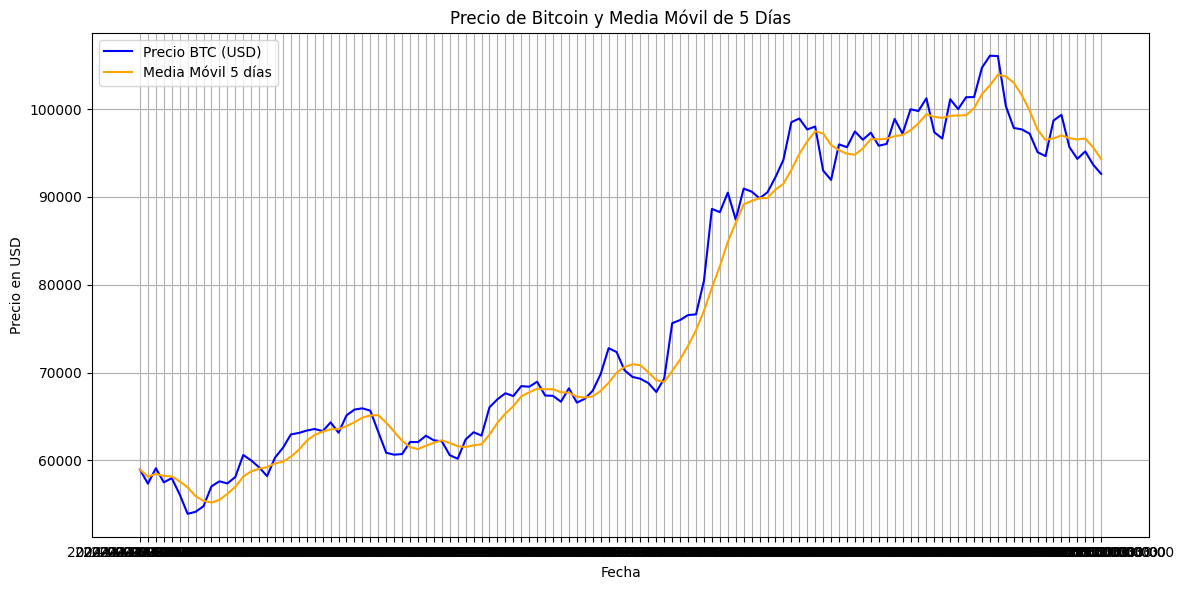

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(dfPandas['fecha'], dfPandas['USD'], label='Precio BTC (USD)', color='blue')
plt.plot(dfPandas['fecha'], dfPandas['media_movil_5d'], label='Media Móvil 5 días', color='orange')
plt.title('Precio de Bitcoin y Media Móvil de 5 Días')
plt.xlabel('Fecha')
plt.ylabel('Precio en USD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()